# Mars Perseverance Waypoints
> This notebook reads and processes hundreds of daily json files listing the locations traveled by the rover since March 2021. 

#### Load Python tools and Jupyter config

In [64]:
import os
import json
import requests
import pandas as pd
import jupyter_black
import altair as alt
from glob import glob
import geopandas as gpd
from shapely.geometry import Point, LineString

In [3]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

In [4]:
today = pd.Timestamp("today").strftime("%Y%m%d")

---

## Read and combine

#### List all JSON files showing daily activity in the directory

In [104]:
files = glob("data/raw/waypoints_current_*.json")
files[:5]

['data/raw/waypoints_current_2021-08-07.json',
 'data/raw/waypoints_current_2023-03-10.json',
 'data/raw/waypoints_current_2021-04-24.json',
 'data/raw/waypoints_current_2021-06-19.json',
 'data/raw/waypoints_current_2022-07-17.json']

#### Read each file, normalize the json structure, assign a date column from file name and append in a list

In [24]:
dfs = []

for file in files:
    base = os.path.basename(file)
    date_str = base.replace("waypoints_current_", "").replace(".json", "")

    try:
        with open(file) as f:
            data = json.load(f)
    except json.JSONDecodeError:
        print(f"Skipping file {file} due to JSON decoding error.")
        continue

    # Extract 'features'
    features = data["features"]

    # Create a list to collect properties from all features
    all_features_properties = []

    # Loop through each feature to normalize its properties
    for feature in features:
        properties = feature["properties"]
        properties["date"] = date_str  # Add the date to each property
        all_features_properties.append(properties)

    # Convert the list of properties dictionaries into a dataframe
    properties_df = pd.DataFrame(all_features_properties)

    # Append that dataframe to our list
    dfs.append(properties_df)

#### Concatenate all the daily dataframes

In [25]:
all_data_df = pd.concat(dfs, ignore_index=True)

#### Convert longitude and latitude to geometric points and create geodataframe

In [84]:
geometry = [Point(xy) for xy in zip(all_data_df["lon"], all_data_df["lat"])]
geo_df = gpd.GeoDataFrame(all_data_df, geometry=geometry)

#### Ensure correct data types for potential date manipulation later

In [85]:
geo_df["date"] = pd.to_datetime(geo_df["date"])

#### Sort geodataframe by earliest date

In [86]:
geo_df = geo_df.sort_values("date", ascending=False)

---

## Process

#### Filter rows where 'images' is not NaN and contains data

In [87]:
has_images = geo_df["images"].apply(lambda x: isinstance(x, list) and len(x) > 0)

#### Empty dataframe to hold the normalized images data

In [88]:
images_df = pd.DataFrame()

#### Normalize and extract 'images' data where applicable

In [89]:
if has_images.any():
    # Normalize the 'images' data for rows that have it and reset index for merging
    images_info = pd.json_normalize(
        geo_df[has_images]["images"].explode()
    ).reset_index()
    # Select and rename columns if necessary from images_info
    selected_columns = images_info.drop_duplicates("index").set_index("index")

#### Merge the extracted 'images' data back into the original geodataframe

In [90]:
# Use a left join to keep all original rows, adding the new columns where available
geo_df = geo_df.merge(
    selected_columns, left_index=True, right_index=True, suffixes=(None, "_drop")
)

#### Clean up the columns

In [91]:
geo_df = geo_df[[col for col in geo_df.columns if not col.endswith("_drop")]]
geo_df = geo_df[[col for col in geo_df.columns if not col.endswith("_y")]]
geo_df = geo_df[[col for col in geo_df.columns if not col.endswith("_x")]]

#### Drop columns with all null values

In [92]:
geo_df_slim = geo_df.dropna(axis=1, how="any")
geo_df_cleaned = geo_df_slim.dropna(subset=["geometry"])

#### The result

In [93]:
len(geo_df_cleaned)

494

In [94]:
geo_df_cleaned.head()

,RMC,site,drive,sol,easting,northing,elev_geoid,elev_radii,radius,roll,pitch,yaw,tilt,dist_m,dist_km,dist_mi,Note,date,geometry,name,isPanoramic,url,rows,columns,azmin,azmax,elmin,elmax,elzero
173,51_2578,51,2578,1109,4347334.516,1096047.789,-2369.412354,-4057.827637,3392132.172,1.965227,6.532164,-101.441674,6.820156,41.298,25.26,15.7,Used Mobility Report WID 41091,2024-04-04,POINT (77.32354 18.49099),Panorama,True,Layers/mosaics/N_LRGB_0933_RZS_0460000_CYL_L_AUTOGENJ01.jpg,1607,3723,146.157,218.282,-58.4867,-27.3526,-1411.04
307,51_2578,51,2578,1109,4347334.516,1096047.789,-2369.412354,-4057.827637,3392132.172,1.965227,6.532164,-101.441674,6.820156,41.298,25.26,15.7,Used Mobility Report WID 41091,2024-04-03,POINT (77.32354 18.49099),Panorama,True,Layers/mosaics/N_LRGB_0797_RZS_0391170_CYL_L_AUTOGENJ01.jpg,2351,9292,0,360,-70.9031,20.1864,522.049
411,51_1904,51,1904,1106,4347392.339,1096040.721,-2372.669678,-4061.23877,3392128.761,0.247698,10.550938,-72.474748,10.553813,1.283,25.17,15.64,Used Mobility Report WID 31061,2024-03-31,POINT (77.32457 18.49087),Panorama,True,Layers/mosaics/N_LRGB_0709_RZS_0332864_CYL_L_AUTOGENJ01.jpg,4363,15459,165.054,104.514,-68.9609,15.568,804.679
415,51_1886,51,1886,1103,4347393.291,1096040.42,-2372.846191,-4061.415527,3392128.584,-0.189,8.061,-76.839,8.063,52.111,25.165,15.637,Used Mobility Report WID 41031,2024-03-30,POINT (77.32459 18.49086),Panorama,True,Layers/mosaics/N_LRGB_0706_RZS_0330430_CYL_L_AUTOGENJ01.jpg,2487,9292,0,360,-66.3513,30,775.355
380,51_1590,51,1590,1102,4347437.457,1096037.272,-2375.036133,-4063.509521,3392126.49,-1.834,-2.621,-137.155,3.199,33.877,25.113,15.604,Used Mobility Report WID 51021,2024-03-27,POINT (77.32537 18.49081),Panorama,True,Layers/mosaics/N_LRGB_0736_RZS_0370000_CYL_L_AUTOGENJ02.jpg,2273,9292,0,360,-74.3005,13.7756,356.575


<Axes: >

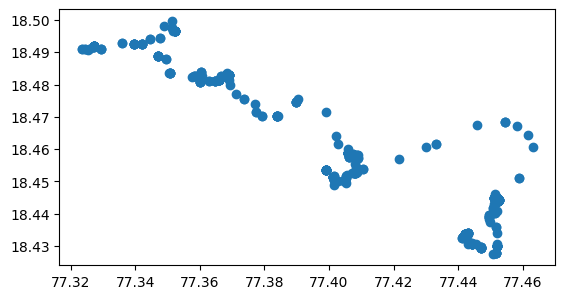

In [95]:
geo_df_cleaned.plot()

#### Convert points to linestring to get rover path

In [96]:
from shapely.geometry import LineString
import geopandas as gpd

# Verify that the GeoDataFrame is not empty and contains Point geometries
if not geo_df_cleaned.empty and all(geo_df_cleaned.geometry.type == 'Point'):
    # Extract coordinate tuples from each Point geometry
    coords = [point.coords[0] for point in geo_df_cleaned.geometry]

    # Ensure there are at least two points to form a LineString
    if len(coords) >= 2:
        # Create the LineString from the list of coordinate tuples
        linestring = LineString(coords)
        # Create a new GeoDataFrame with this LineString
        linestrings_gdf = gpd.GeoDataFrame(geometry=[linestring], crs=geo_df_cleaned.crs)
        print(linestrings_gdf)
    else:
        print("Not enough points to form a LineString.")
else:
    print("GeoDataFrame is empty or does not contain valid Point geometries.")

IndexError: index out of range

#### Remove rows with None, NaN, or empty geometries

In [ ]:
valid_geo_df = geo_df_cleaned[
    ~(
        geo_df_cleaned.geometry.isnull()
        | geo_df_cleaned.geometry.apply(lambda geom: geom.is_empty)
    )
]

print(f"Valid geometries count: {len(valid_geo_df)}")

In [ ]:
if not valid_geo_df.empty:
    # Extract coordinate tuples from each Point geometry
    coords = [(point.x, point.y) for point in valid_geo_df.geometry]

    # Ensure there are at least two points to form a LineString
    if len(coords) >= 2:
        # Create the LineString from the list of coordinate tuples
        linestring = LineString(coords)
        # Create a new GeoDataFrame with this LineString
        linestrings_gdf = gpd.GeoDataFrame(geometry=[linestring], crs=valid_geo_df.crs)
    else:
        print("Not enough points to form a LineString.")
else:
    print("No valid geometries to form a LineString.")

<Axes: >

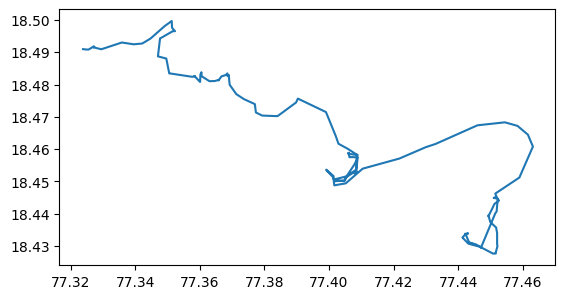

In [103]:
linestrings_gdf.plot()

---

## Exports

#### Rover path as linestring

In [17]:
gdf.to_file(
    f"data/processed/rover_path_full.geojson",
    driver="GeoJSON",
)

#### CSV

In [18]:
# df.to_csv(
#     f"data/processed/NAME.csv", index=False
# )

#### GeoJSON

In [19]:
# gdf.to_file(
#     f"data/processed/NAME.geojson",
#     driver="GeoJSON",
# )